#Generate english transliteration of the given hindi text trained using the given dataset.

This is a text to text translation problem. **I will use Neural Machine Translation with Atention**
A sequence to sequence model for Hindi to English translation using tensorflow keras.

In [23]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.14.0


### Download dataset

Dataset source : http://www.manythings.org/anki/. 

As per the requirement, I am using Hin-Eng file from the list. 

In [24]:
file_path ="hin.txt"

# For testing if the file is loaded successfully, we can print few lines from the file using:
temp = open(file_path, encoding='UTF-8').read().strip().split('\n')
temp[0:5]
len(temp)

2808

In [0]:
# We need to convert unicode file to ascii

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  
  # We need to add space between every word and punctuation such as : "Wow! It is done." -> "Wow ! It is done ."
  # This is because out network recognises these characters as different words.
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
    
  # We also need every thing with space except alphabets, punctuations and assisting symbols
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.rstrip().strip()
  
  # Adding a start and end token to the sentence
  w = '<start> ' + w + ' <end>'
  return w

In [0]:
# Few preprocessing tasks such as:
# 1. Removing accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, HINDI]

def create_dataset(path, num_examples):
  lines =  open(path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  
  return word_pairs

In [0]:
# Creating word-index mapping (e.g. "wow"->7) for both the language.

class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))

    self.vocab = sorted(self.vocab)

    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1

    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
  # creating cleaned input and output pairs
  pairs = create_dataset(path, num_examples)
  
  # index language using the class defined above
  inp_lang = LanguageIndex(hi for en, hi in pairs)
  targ_lang = LanguageIndex(en for en, hi in pairs)
  
  # Vectorize the input and target languages
  
  # Hindi sentences
  input_tensor = [[inp_lang.word2idx[s] for s in hi.split(' ')] for en, hi in pairs]
  
  # English sentences
  target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
  
  # We set input vector size to the size of longest sentence (sentence with maximum length) in out dataset.
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
  # We need to add padding other sentences before using them. We will pad the input and output tensor to max-length
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
  
  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
  
  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [0]:
num_examples = len(temp)
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(file_path, num_examples)

In [30]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(2246, 2246, 562, 562)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### Writing Encoder and Decoder model

The model will be an Attention model

In [0]:
def gru(units):
  return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.enc_units)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)        
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.dec_units)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.W1 = tf.keras.layers.Dense(self.dec_units)
    self.W2 = tf.keras.layers.Dense(self.dec_units)
    self.V = tf.keras.layers.Dense(1)
        
  def call(self, x, hidden, enc_output):
    #  enc_output shape == (batch_size, max_length, hidden_size)
        
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
    score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * enc_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size * 1, vocab)
    x = self.fc(output)

    return x, state, attention_weights

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.dec_units))    

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

### Defining optimizer and loss function

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1-np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [0]:
# saving the checkpoints
checkpoint_dir = checkpoint_prefix = os.path.join('', "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

In [38]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()
    
  hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset):
    loss = 0
        
    with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    total_loss += batch_loss

    variables = encoder.variables + decoder.variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  

Epoch 1 Batch 0 Loss 2.3199
Epoch 2 Batch 0 Loss 1.5416
Epoch 3 Batch 0 Loss 1.4035
Epoch 4 Batch 0 Loss 1.3030
Epoch 5 Batch 0 Loss 1.2142
Epoch 6 Batch 0 Loss 1.1428
Epoch 7 Batch 0 Loss 1.0845
Epoch 8 Batch 0 Loss 1.0404
Epoch 9 Batch 0 Loss 0.9963
Epoch 10 Batch 0 Loss 0.9545
Epoch 11 Batch 0 Loss 0.9194
Epoch 12 Batch 0 Loss 0.9101
Epoch 13 Batch 0 Loss 0.8894
Epoch 14 Batch 0 Loss 0.8421
Epoch 15 Batch 0 Loss 0.8254
Epoch 16 Batch 0 Loss 0.8071
Epoch 17 Batch 0 Loss 0.7773
Epoch 18 Batch 0 Loss 0.7578
Epoch 19 Batch 0 Loss 0.7375
Epoch 20 Batch 0 Loss 0.7252
Epoch 21 Batch 0 Loss 0.7125
Epoch 22 Batch 0 Loss 0.6953
Epoch 23 Batch 0 Loss 0.6785
Epoch 24 Batch 0 Loss 0.6684
Epoch 25 Batch 0 Loss 0.6643
Epoch 26 Batch 0 Loss 0.6553
Epoch 27 Batch 0 Loss 0.6571
Epoch 28 Batch 0 Loss 0.6582
Epoch 29 Batch 0 Loss 0.6594
Epoch 30 Batch 0 Loss 0.6456
Epoch 31 Batch 0 Loss 0.6279
Epoch 32 Batch 0 Loss 0.6170
Epoch 33 Batch 0 Loss 0.6118
Epoch 34 Batch 0 Loss 0.6074
Epoch 35 Batch 0 Loss 0

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    # storing the attention weigths to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.idx2word[predicted_id] + ' '

    if targ_lang.idx2word[predicted_id] == '<end>':
        return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
  result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start>  <end>
Predicted translation: i m going to the door . <end> 


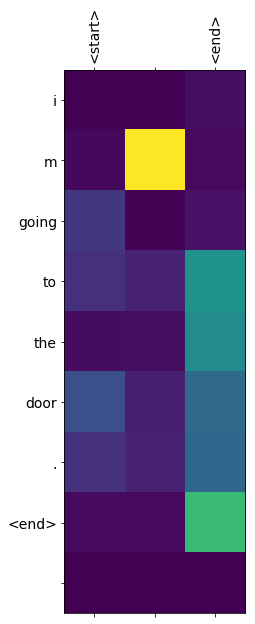

In [42]:
translate(u'मैंने अपना काम पूरा किया', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)